# Connect to database

_Some initial imports and definitions:_

In [5]:
import pymongo as pm
from pymongo.errors import ConnectionFailure
from time import sleep
from ssl import CERT_NONE
import pandas as pd
import numpy as np

from IPython.core.display import HTML
display(HTML('<h1>Hello, world!</h1>'))

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import matplotlib.pyplot as plt

pd.options.display.max_columns = None



def save_to_file(filename, fig=None):
    """Save to @filename with a custom set of file formats.
    
    By default, this function takes to most recent figure,
    but a @fig can also be passed to this function as an argument.
    """
    formats = [
                "pdf",
                "eps",
                "png",
                "svg",
              ]
    if fig is None:
        for form in formats:
            plt.savefig("%s.%s"%(filename, form))
    else:
        for form in formats:
            fig.savefig("%s.%s"%(filename, form))

def header(h):
    display(HTML('<h1>%s</h1>' % h))

In [2]:
# Connect to our DB

client = pm.MongoClient('10.210.9.130', ssl=True, ssl_cert_reqs=CERT_NONE,
                        username='strands', authSource='admin', authMechanism='SCRAM-SHA-1',
                        serverSelectionTimeoutMS=5000, password='Grum#Beere')
#client = pm.MongoClient('lcas.lincoln.ac.uk', port=80)
#try:
   # The ismaster command is cheap and does not require auth.
dbs = {
    'y4': client.aafy4_message_store,
    'y3': client.aafy3_message_store,
    'y2': client.aafy2_message_store
}



In [3]:

#df = pd.DataFrame(list(dbs['y4']['nav_stats'].find({})))

df = pd.DataFrame.from_records(dbs['y2']['nav_stats'].find({'status': 'failed'}))
#display(df.head())
#df[['final_node']].drop_duplicates()
#df[['operation_time']].mean()
#df.shape[0]
df.head()

,_id,_meta,date_at_node,date_finished,date_started,edge_id,final_node,mon_events,operation_time,origin,status,target,time_to_waypoint,topological_map
0,55598e21681244049ef0b2f0,"{'inserted_at': 2015-05-18 07:00:49.959000, 's...","Monday, May 18 2015, at 09:00:49 hours","Monday, May 18 2015, at 09:00:49 hours","Monday, May 18 2015, at 09:00:49 hours",WayPoint86_WayPoint90,WayPoint86,[],0.828023,WayPoint86,failed,WayPoint90,0.000000,aaf_deployment
1,555990ef681244049ef0b61c,"{'inserted_at': 2015-05-18 07:12:47.913000, 's...","Monday, May 18 2015, at 09:12:47 hours","Monday, May 18 2015, at 09:12:47 hours","Monday, May 18 2015, at 09:12:47 hours",WayPoint26_WayPoint90,WayPoint26,[],0.619103,WayPoint26,failed,WayPoint90,0.000000,aaf_deployment
2,55599183681244049ef0b8d8,"{'inserted_at': 2015-05-18 07:15:15.435000, 's...","Monday, May 18 2015, at 09:15:13 hours","Monday, May 18 2015, at 09:15:15 hours","Monday, May 18 2015, at 09:14:58 hours",WayPoint88_Kindergarten,Kindergarten,[],17.021091,WayPoint88,failed,Kindergarten,2.381081,aaf_deployment
3,55599c69681244049ef10cfd,"{'inserted_at': 2015-05-18 08:01:45.338000, 's...","Monday, May 18 2015, at 10:01:44 hours","Monday, May 18 2015, at 10:01:45 hours","Monday, May 18 2015, at 10:01:44 hours",WayPoint86_WayPoint90,WayPoint86,[],0.828731,WayPoint86,failed,WayPoint90,0.000000,aaf_deployment
4,55599e96681244049ef11538,"{'inserted_at': 2015-05-18 08:11:02.321000, 's...","Monday, May 18 2015, at 10:11:01 hours","Monday, May 18 2015, at 10:11:02 hours","Monday, May 18 2015, at 10:11:01 hours",WayPoint26_WayPoint90,WayPoint26,[],0.759469,WayPoint26,failed,WayPoint90,0.000000,aaf_deployment


In [6]:
# monitored nav events
coll = dbs['y4']['monitored_nav_events']
#print(coll.count())
pipeline = [
    {
        '$limit': 5000
    },
    {
        '$project': {
            'start_pose_x': '$event_start_pose.position.x',
            'start_pose_y': '$event_start_pose.position.y',
            'end_pose_x': '$event_end_pose.position.x',
            'end_pose_y': '$event_end_pose.position.y',
            'start_time': {'$add': ['$event_start_time.secs', {'$divide': ['$event_start_time.nsecs', 1000000000.0]}]},
            'start_time_secs': '$event_start_time.secs',
            'start_time_nsecs': '$event_start_time.nsecs',
            'end_time': {'$add': ['$event_end_time.secs', {'$divide': ['$event_end_time.nsecs', 1000000000.0]}]},
            'end_time_secs': '$event_end_time.secs',
            'end_time_nsecs': '$event_end_time.nsecs',
            'was_helped': 1, 'n_help_requests': 1,
            'edge_id': 1,
            'recover_mechanism': 1,
            'inserted_at': '$_meta.inserted_at'
        }
    }
]

agg = coll.aggregate(pipeline)

df_mne = pd.DataFrame.from_records(agg)

# compute calculated columns
df_mne['duration'] = (df_mne.end_time - df_mne.start_time)
df_mne['inserted_at_secs'] = df_mne.inserted_at.astype(np.int64) // 10**9
df_mne.set_index('inserted_at_secs', drop=False, inplace=True)
df_mne.sort_index(inplace=True)

df_mne.to_pickle('MNE_y4.p')
df_mne.head()


,_id,edge_id,end_pose_x,end_pose_y,end_time,end_time_nsecs,end_time_secs,inserted_at,n_help_requests,recover_mechanism,start_pose_x,start_pose_y,start_time,start_time_nsecs,start_time_secs,was_helped,duration,inserted_at_secs
inserted_at_secs,,,,,,,,,,,,,,,,,,
1478607207,5821c167b63c4d097bada237,,-18.140426,-70.186561,1.478607e+09,504234075,1478607207,2016-11-08 12:13:27.740,1,sleep_and_retry,-18.140426,-70.186561,1.478607e+09,137943983,1478607201,False,6.366290,1478607207
1478607228,5821c17cb63c4d097bada239,,-18.140426,-70.186561,1.478607e+09,617881059,1478607228,2016-11-08 12:13:48.669,2,backtrack,-18.140426,-70.186561,1.478607e+09,448864936,1478607225,False,3.169016,1478607228
1478607260,5821c19cb63c4d097bada23b,,-18.026326,-69.862764,1.478607e+09,672528982,1478607260,2016-11-08 12:14:20.933,1,sleep_and_retry,-18.026326,-69.862764,1.478607e+09,452892065,1478607254,False,6.219637,1478607260
1478607301,5821c1c5b63c4d097bada23d,,-18.594153,-70.210300,1.478607e+09,328999042,1478607301,2016-11-08 12:15:01.503,2,backtrack,-18.026326,-69.862764,1.478607e+09,197510004,1478607278,False,23.131489,1478607301
1478607324,5821c1dcb63c4d097bada23f,,-18.592843,-70.209768,1.478607e+09,986634016,1478607323,2016-11-08 12:15:24.080,3,backtrack,-18.594153,-70.210300,1.478607e+09,714020967,1478607319,False,4.272613,1478607324


In [7]:
# nav_stats
import numpy as np
coll = dbs['y4']['nav_stats']

pipeline = [
    {
        '$match': {
        }
    },
    {
        '$project': {
            'date_finished': 1,
            'date_start': 1,
            'origin': 1,
            'final_node': 1,
            'target': 1,
            'operation_time': 1, 'status': 1,
            'edge_id': 1,
            'topological_map': 1,
            'inserted_at': '$_meta.inserted_at'
        }
    }
]

agg = coll.aggregate(pipeline)

df_ns = pd.DataFrame.from_records(agg)

# compute calculated columns
df_ns['inserted_at_secs'] = df_ns.inserted_at.astype(np.int64) // 10**9
df_ns['start_at_secs'] = np.int64(df_ns.inserted_at_secs - df_ns.operation_time)
df_ns.set_index('start_at_secs', drop=False, inplace=True)
df_ns.sort_index(inplace=True)
df_ns.to_pickle('nav_stats_y4.p')
display(df_ns.head())
print(df_ns.shape)

,_id,date_finished,edge_id,final_node,inserted_at,operation_time,origin,status,target,topological_map,inserted_at_secs,start_at_secs
start_at_secs,,,,,,,,,,,,
1480274123,583b30dfb63c4d6eb86ff88e,"Sunday, November 27 2016, at 20:15:43 hours",Station_ChargingPoint,ChargingPoint,2016-11-27 19:15:43.999,19.893930,Station,success,ChargingPoint,aaf_y4,1480274143,1480274123
1480274367,583b31d7b63c4d6eb86ff88f,"Sunday, November 27 2016, at 20:19:51 hours",ChargingPoint_Station,Station,2016-11-27 19:19:51.098,23.572407,ChargingPoint,success,Station,aaf_y4,1480274391,1480274367
1480274458,583b322eb63c4d6eb86ff890,"Sunday, November 27 2016, at 20:21:18 hours",Station_ChargingPoint,ChargingPoint,2016-11-27 19:21:18.512,19.336452,Station,success,ChargingPoint,aaf_y4,1480274478,1480274458
1480318516,583bde4ab63c4d6eb86ff8a6,"Monday, November 28 2016, at 08:35:38 hours",ChargingPoint_Station,Station,2016-11-28 07:35:38.749,21.574658,ChargingPoint,success,Station,aaf_y4,1480318538,1480318516
1480318538,583bde53b63c4d6eb86ff8a7,"Monday, November 28 2016, at 08:35:47 hours",Station_WayPoint91,WayPoint91,2016-11-28 07:35:47.600,8.723706,Station,success,WayPoint91,aaf_y4,1480318547,1480318538


(32959, 12)


joined valid rows: 3776 (out of 4273 original MNEs)


failed     1570
success    1111
fatal       415
Name: status, dtype: int64

status,failed,fatal,success,All
recover_mechanism,,,,
backtrack,291.0,64.0,211.0,566.0
carpet_backtrack,0.0,3.0,0.0,3.0
nav_help,1037.0,254.0,167.0,1458.0
recover_bumper,119.0,129.0,270.0,518.0
recover_stuck_on_carpet,12.0,31.0,21.0,64.0
sleep_and_retry,289.0,48.0,506.0,843.0
walking_group_help,182.0,85.0,57.0,324.0
All,1930.0,614.0,1232.0,3776.0


status,failed,fatal,success,All
recover_mechanism,,,,
backtrack,7.706568,1.694915,5.587924,14.989407
carpet_backtrack,0.000000,0.079449,0.000000,0.079449
nav_help,27.462924,6.726695,4.422669,38.612288
recover_bumper,3.151483,3.416314,7.150424,13.718220
recover_stuck_on_carpet,0.317797,0.820975,0.556144,1.694915
sleep_and_retry,7.653602,1.271186,13.400424,22.325212
walking_group_help,4.819915,2.251059,1.509534,8.580508
All,51.112288,16.260593,32.627119,100.000000


status,failed,fatal,success,All
recover_mechanism,,,,
backtrack,22.441665,17.896907,21.619072,21.621115
carpet_backtrack,0.000000,95.029067,0.000000,95.029067
nav_help,36.238817,21.177349,31.520034,33.074448
recover_bumper,21.640981,58.168487,18.676073,29.192184
recover_stuck_on_carpet,1.676304,1.572992,1.632082,1.611752
sleep_and_retry,6.020417,5.858364,6.029484,6.016632
walking_group_help,0.865903,7.640564,8.835192,4.045210
All,25.182935,24.906650,14.981176,21.809469


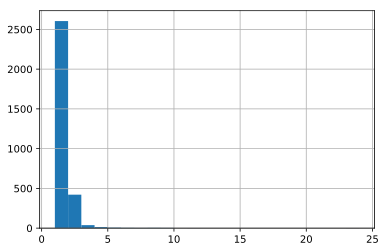

In [20]:
# join the MNE with the NS, driven by MNEs. Match based on computed start time of the NS and the insertion of the MNE, 
# cut off of 10 minutes (600 secs) to only return reasonable matches) 
df_join = pd.merge_asof(
    df_mne, df_ns, left_on='inserted_at_secs', right_on='start_at_secs', tolerance=np.int64(600),
    suffixes=['_MNE', '_NS'])

# drop anything that couldn't be matches (we only look at MNE that have an actual NS)
df_join.dropna(inplace=True)

# compute timediff between start of NS and the MNE 
df_join['diff'] = (df_join.inserted_at_secs_MNE - df_join.start_at_secs)

print('joined valid rows: %d (out of %d original MNEs)' % (
    df_join.shape[0], df_mne.shape[0])
)

df_join['id_NS'] = df_join['_id_NS'].astype('str')
df_join['id_MNE'] = df_join['_id_MNE'].astype('str')

df_NS_clean = df_join.drop_duplicates(subset=['_id_NS'])

header('number of different outcomes in NS:')
display(df_NS_clean['status'].value_counts())

#df_join.loc[df_join['id_NS'] == '583d6eb5b63c4d6eb871128e']

header('pivot table in absolute numbers of navigation stats:')
pt = pd.pivot_table(
    df_join, values='duration', index=['recover_mechanism'],
    columns=['status'], aggfunc='count', margins=True,
    fill_value=0)

display(pt)

header('pivot table in relative % of navigation stats:')
pt = pd.pivot_table(
    df_join, values='duration', index=['recover_mechanism'],
    columns=['status'], aggfunc='count', margins=True,
    fill_value=0).div(len(df_join.index)).mul(100)

display(pt)


header('pivot table of mean duration of navigation stats:')
pt = pd.pivot_table(
    df_join, values='duration', index=['recover_mechanism'],
    columns=['status'], aggfunc=np.mean, margins=True,
    fill_value=0)

display(pt)
#df_join.dtypes

header('Histogram of number of MNE per NS:')

df_individual_NS = df_join.groupby(['id_NS'])['id_MNE'].nunique()
df_individual_NS.hist(bins=range(1,25))

data spans 156 days


,_id,edge_id,end_pose_x,end_pose_y,end_time,end_time_nsecs,end_time_secs,inserted_at,n_help_requests,recover_mechanism,start_pose_x,start_pose_y,start_time,start_time_nsecs,start_time_secs,was_helped,duration,inserted_at_secs,day
inserted_at_secs,,,,,,,,,,,,,,,,,,,
1478607207,5821c167b63c4d097bada237,,-18.140426,-70.186561,1.478607e+09,504234075,1478607207,2016-11-08 12:13:27.740,1,sleep_and_retry,-18.140426,-70.186561,1.478607e+09,137943983,1478607201,False,6.366290,1478607207,17113.0
1478607228,5821c17cb63c4d097bada239,,-18.140426,-70.186561,1.478607e+09,617881059,1478607228,2016-11-08 12:13:48.669,2,backtrack,-18.140426,-70.186561,1.478607e+09,448864936,1478607225,False,3.169016,1478607228,17113.0
1478607260,5821c19cb63c4d097bada23b,,-18.026326,-69.862764,1.478607e+09,672528982,1478607260,2016-11-08 12:14:20.933,1,sleep_and_retry,-18.026326,-69.862764,1.478607e+09,452892065,1478607254,False,6.219637,1478607260,17113.0
1478607301,5821c1c5b63c4d097bada23d,,-18.594153,-70.210300,1.478607e+09,328999042,1478607301,2016-11-08 12:15:01.503,2,backtrack,-18.026326,-69.862764,1.478607e+09,197510004,1478607278,False,23.131489,1478607301,17113.0
1478607324,5821c1dcb63c4d097bada23f,,-18.592843,-70.209768,1.478607e+09,986634016,1478607323,2016-11-08 12:15:24.080,3,backtrack,-18.594153,-70.210300,1.478607e+09,714020967,1478607319,False,4.272613,1478607324,17113.0
1478607382,5821c216b63c4d097bada241,,-16.683038,-70.310296,1.478607e+09,400078058,1478607382,2016-11-08 12:16:22.625,2,recover_bumper,-18.592843,-70.209768,1.478607e+09,115691900,1478607324,False,58.284386,1478607382,17113.0
1478608354,5821c5e2b63c4d097bada26a,,-28.700127,-74.875314,1.478608e+09,155313014,1478608354,2016-11-08 12:32:34.432,1,sleep_and_retry,-28.700127,-74.875314,1.478608e+09,919209957,1478608347,False,6.236103,1478608354,17113.0
1478608372,5821c5f4b63c4d097bada26c,,-28.700127,-74.875314,1.478608e+09,25638103,1478608372,2016-11-08 12:32:52.082,2,backtrack,-28.700127,-74.875314,1.478608e+09,342571020,1478608361,False,10.683067,1478608372,17113.0
1478608412,5821c61cb63c4d097bada26d,,-28.700127,-74.875314,1.478608e+09,276782035,1478608412,2016-11-08 12:33:32.379,2,nav_help,-28.700127,-74.875314,1.478608e+09,89374065,1478608372,False,40.187408,1478608412,17113.0


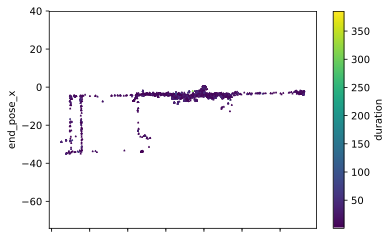

In [24]:

df_mne['day'] = df_mne.start_time // (60 * 60 * 24)
first_day = df_mne['day'].min()
last_day = df_mne['day'].max()
print('data spans %d days' % (last_day - first_day))
# shift days to start date to begin with 0


df_mne.plot.scatter(y='end_pose_x', x='end_pose_y', colormap='viridis', s=1, marker='^', c='duration').set_aspect('equal', 'datalim')
df_mne.head(10)

#save_to_file('MNE_y4_map')